In [60]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import torch
import numpy as np
from utils import *

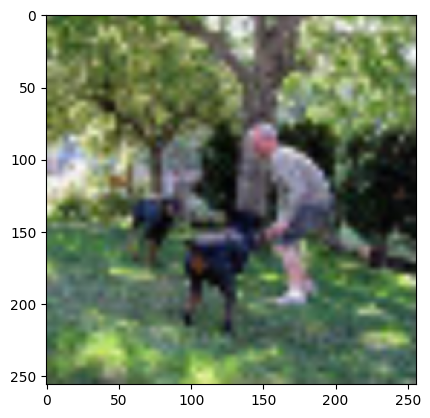

In [62]:
import cv2
import matplotlib.pyplot as plt
im = cv2.imread("testdata/Val_SR/lq/ILSVRC2012_val_00000134.png")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, dsize=(256,256))
plt.imshow(im)

In [63]:
lq = ((torch.tensor(im).permute(2, 0, 1)[None] / 255.) - 0.5) * 2.

In [64]:
import yaml

with open("autoencoder.yaml") as file:
    config = yaml.safe_load(file)

In [65]:
ae_config = config["autoencoder"]
ae = instantiate_from_config(ae_config)
ae = prepare_model(ae, ae_config).cuda()

Working with z of shape (1, 3, 64, 64) = 12288 dimensions.


In [66]:
lt = ae.encode(lq.cuda())

In [67]:
rec = ae.decode(lt)

In [68]:
def plot_tensor(out):
    out = (out[0].permute(1, 2, 0).detach().cpu().numpy() + 1.) * 0.5
    plt.imshow(out)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


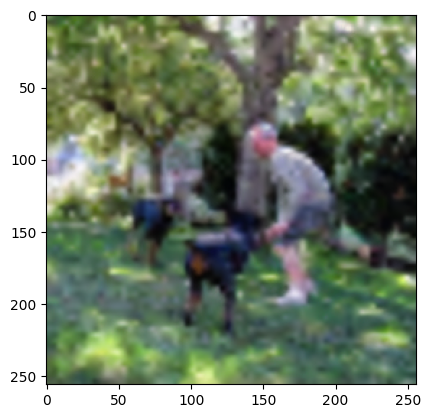

In [69]:
plot_tensor(rec)

In [70]:
model_config = config["model"]
model = instantiate_from_config(model_config)
model = prepare_model(model, model_config)
model.cuda()

UNetModelSwin(
  (time_embed): Sequential(
    (0): Linear(in_features=160, out_features=640, bias=True)
    (1): SiLU()
    (2): Linear(in_features=640, out_features=640, bias=True)
  )
  (feature_extractor): Identity()
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(6, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 160, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=640, out_features=320, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 160, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2

In [91]:
def add_noise(x, eta_end=0.999, kappa=2.0):
    return x + torch.randn_like(x) * kappa * eta_end**0.5

In [92]:
def q_sample(x, y, eta, kappa=2.0):
    return x + eta * (y - x) + \
        eta**0.5 * kappa * torch.randn_like(x) * kappa * eta**0.5

In [93]:
# lt_noised = q_sample(lt, lt, 0.159395)
lt_noised = add_noise(lt)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


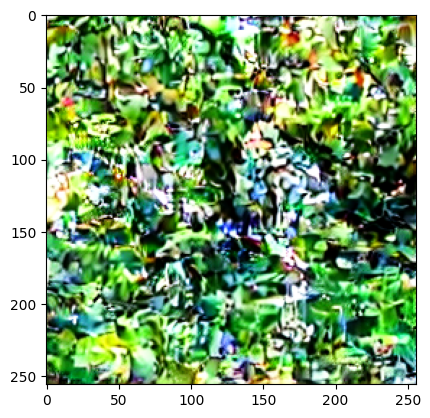

In [94]:
plot_tensor(ae.decode(lt_noised.cuda()))

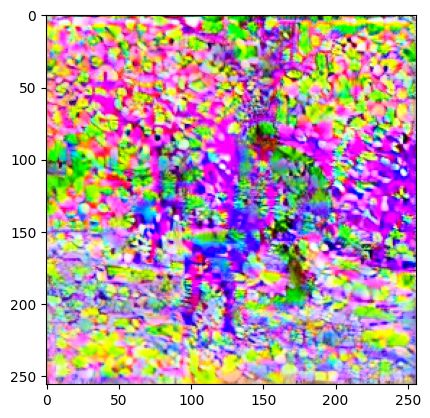

In [95]:
timesteps = torch.tensor([4])
sr = model(lt_noised.cuda(), timesteps.cuda(), lt.cuda())
out = ae.decode(sr).clip(-1, 1)
plot_tensor(out)

In [88]:
import numpy as np
a=1.9248
T=15
alpha_T= 2.1112561
lamb=np.log(1+alpha_T/a)

def alpha_fn(t, a=a, alpha_T=alpha_T, T=T): 
  lamb=np.log(1+alpha_T/a) 
  return a*(np.exp(lamb*t)-1) 
def eta_fn(t, a=a, alpha_T=alpha_T, T=T): 
  lamb=np.log(1+alpha_T/a) 
  return a*((np.exp(lamb*t)-1)/lamb-t)

class Solver:
  def __init__(
    self,
    x0_pred_fn,
    a=0.2032,
    alpha_T_prime=0.14075041,
    T=15,
    kappa=2.0, 
    device="cpu"
  ):
    self.alpha_fn = lambda t: alpha_fn(t, a, alpha_T_prime, T)
    self.eta_fn = lambda t: eta_fn(t, a, alpha_T_prime, T)
    self.T = T
    self.kappa = kappa
    self.x0_pred_fn = x0_pred_fn.to(device)
    self.device = device

    self.f = lambda alpha, e0, score:\
              alpha * e0 - 0.5 * alpha * self.kappa**2 * score

  def _get_score_with_x0(self, x, step_idx, x0, y0):
    eta = self._etas[step_idx]
    alpha = self._alphas[step_idx]
    return -(x - x0 * (1 - eta) - eta * y0) / (self.kappa**2 * alpha)

  def ode_step(self, x, step_idx, y0):
    curr_timestep = torch.tensor([self._timesteps[step_idx]] * len(x), dtype=x.dtype, device=x.device)
    alpha = self._alphas[step_idx]

    x0 = y0 # self.x0_pred_fn(x, curr_timestep * self.T - 1, y0)
    # tmp = (x0[0].permute(1, 2, 0).detach().cpu().numpy() * 0.5 + 0.5).astype("float")
    # plt.imshow(tmp)
    # plt.savefig(f"logs/{step_idx}")
    e0 = y0 - x0
    score = self._get_score_with_x0(x, step_idx, x0, y0)

    h = self._timesteps[step_idx + 1] - self._timesteps[step_idx]
    x_next= x + h * self.T * self.f(alpha, e0, score)
    return x_next

  def __call__(self, timesteps, y0, y0_noised):
    self._timesteps = timesteps.to(self.device)
    # self._alphas = self.alpha_fn(timesteps).to(self.device)
    # self._etas = self.eta_fn(timesteps).to(self.device)
    # print(self._alphas)
    # print(self._etas)
    self._alphas = torch.tensor([0, 0.001,      0.02185606, 0.02425545, 0.0304312,  0.03723592, 0.04461637,
                0.05258635, 0.06117047, 0.07039532, 0.08028811, 0.09087679, 0.10218877,
                0.11425269, 0.12709594, 0.14075041,][::-1], device=self.device) / 123
    self._etas = torch.tensor([0, 0.001,      0.02285606, 0.04711151, 0.07754271, 0.11477862, 0.159395,
                  0.21198134, 0.27315181, 0.34354714, 0.42383525, 0.51471204, 0.6169008,
                  0.7311535,  0.8582494,  0.99899983,][::-1], device=self.device) / 12
    print(self._alphas)
    print(self._etas)
    y0 = y0.to(self.device)
    print(timesteps * self.T)
    
    x = y0_noised.to(self.device)
    for i in range(len(timesteps) - 1):
      x = self.ode_step(x, i, y0)
    return x

In [89]:
sv = Solver(model, device="cuda")

tensor([1.1443e-03, 1.0333e-03, 9.2888e-04, 8.3080e-04, 7.3884e-04, 6.5275e-04,
        5.7232e-04, 4.9732e-04, 4.2753e-04, 3.6273e-04, 3.0273e-04, 2.4741e-04,
        1.9720e-04, 1.7769e-04, 8.1301e-06, 0.0000e+00], device='cuda:0')
tensor([8.3250e-02, 7.1521e-02, 6.0929e-02, 5.1408e-02, 4.2893e-02, 3.5320e-02,
        2.8629e-02, 2.2763e-02, 1.7665e-02, 1.3283e-02, 9.5649e-03, 6.4619e-03,
        3.9260e-03, 1.9047e-03, 8.3333e-05, 0.0000e+00], device='cuda:0')
tensor([15., 14., 13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,
         1.,  0.], dtype=torch.float64)


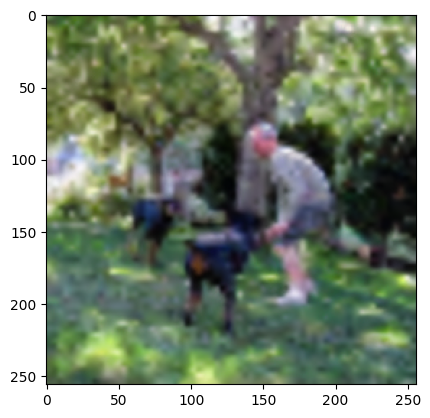

In [90]:
timesteps = torch.tensor(list(np.linspace(0, 1, 16))[::-1])
out = sv(timesteps, lt, lt_noised)
plot_tensor(ae.decode(out).clip(-1, 1))